In [151]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

(175, 400)

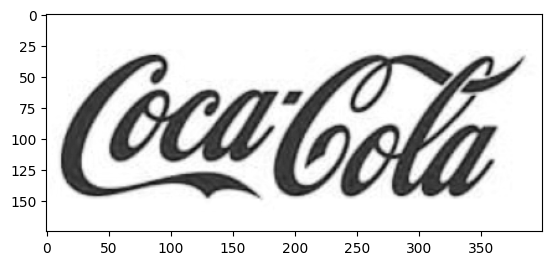

In [152]:
# Cargamos la imagen a procesar
template = cv.imread(r'template\pattern.png',0)
path_temp='template/pattern.png'
plt.figure()
plt.imshow(template, cmap="gray")
template.shape

In [153]:
w_original, h_original = template.shape[::-1]
print (template.shape)
edges = cv.Canny(template, threshold1=5, threshold2=130)
edges = cv.bitwise_not(edges)
print(edges.shape)

(175, 400)
(175, 400)


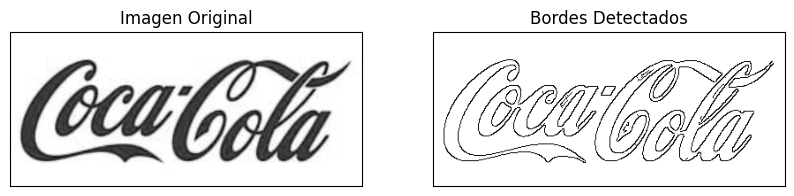

In [154]:
# Visualizamos la imagen original y los bordes detectados
plt.figure(figsize=(10, 5))

# Mostramos la imagen original en el subplot de la izquierda
plt.subplot(1, 2, 1)
plt.imshow(template, cmap='gray')
plt.title('Imagen Original')
plt.xticks([]), plt.yticks([])

# Mostramos los bordes detectados en el subplot de la derecha
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Bordes Detectados')
plt.xticks([]), plt.yticks([])

plt.show()

In [155]:
def detect_img(template_path,img_det_path,method, threshold, multi_img,black_white,multi_det):
    
    template_gris = cv.imread(template_path,0)
    template_gris_bordes = cv.Canny(template_gris, threshold1=400, threshold2=400)
    w_temp, h_temp = template_gris.shape[::-1]
    
    
    img_orig = cv.imread(img_det_path)
    img_rgb = cv.cvtColor(img_orig, cv.COLOR_BGR2RGB)
    img_det_gris = cv.cvtColor(img_orig, cv.COLOR_BGR2GRAY)
    w_img_det, h_img_det = img_det_gris.shape[::-1]
    img_gris_bordes = cv.Canny(img_det_gris, threshold1=400, threshold2=0.7*w_img_det)
    # Visualizamos la imagen original y los bordes detectados
    plt.figure(figsize=(10, 5))

    # Mostramos la imagen original en el subplot de la izquierda
    plt.subplot(1, 2, 1)
    plt.imshow(template_gris_bordes, cmap='gray')
    plt.title('Template')
    plt.xticks([]), plt.yticks([])

    # Mostramos los bordes detectados en el subplot de la derecha
    plt.subplot(1, 2, 2)
    plt.imshow(img_gris_bordes, cmap='gray')
    plt.title('Imagen a detectar')
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    if black_white:
        img_gris_bordes = cv.bitwise_not(img_gris_bordes)
    
    
    
    template_copy = template_gris_bordes.copy()
    
    if (w_temp<w_img_det) :
        aspect_ratio = template_copy.shape[0] / template_copy.shape[1]
        target_width = w_img_det
        target_height = int(target_width * aspect_ratio)
        template_copy = cv.resize(template_copy, (target_width, target_height))
        
    
    maximo = 0
    
    meth = eval(method)
    scales = np.linspace(1, 0.1, 100)
    final_scale = scales[0]
    c_det_escalados=0;
    for scale in scales:
        print("Scale: ",scale,"with template",w_temp,"high template",h_temp)
        print(w_temp,"<",w_img_det,"?", h_temp,"<",h_img_det,"?")
        if ((w_temp<w_img_det) & (h_temp<h_img_det)):
            try:
                # res = cv.matchTemplate(edges, template_resized, meth)
                # min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
                res = cv.matchTemplate(img_gris_bordes,template_copy,meth)
                min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
                loc = np.where( res >= threshold)
                #Si existe alguna deteccion entro
                if (len(loc[0]) > 1):
                    if multi_det==0:
                        print(f"Escala {scale} aceptada","max val:",max_val)
                        final_scale=scale
                        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
                        top_left = max_loc
                        bottom_right = (top_left[0] + w_temp, top_left[1] + h_temp)
                        cv.rectangle(img_rgb, top_left, bottom_right, (0, 0, 255), 3) 
                        cv.putText(img_rgb, str(round(max_val,2)), (top_left[0], top_left[1] - 10), cv.FONT_HERSHEY_DUPLEX, 0.7, (0, 0, 255), 1)
                        break;   
                    else:
                        if c_det_escalados>1:
                            break;
                        # Create a list of boxes and scores using list comprehension
                        boxes = [[pt[0], pt[1], w_temp, h_temp] for pt in zip(*loc[::-1])]
                        scores = [res[pt[1], pt[0]] for pt in zip(*loc[::-1])]

                        # Apply Non-Maximum Suppression (NMS) to filter redundant detections
                        puntos_elegidos = cv.dnn.NMSBoxes(boxes, scores, 0.03, 0.05)

                        #Recorro todas las detecciones y veo cual quedo dentro de las no redundantes
                        for i in puntos_elegidos:
                           
                            pt = tuple(boxes[i][0:2])  
                            cv.rectangle(img_rgb, pt, (pt[0] + w_temp, pt[1] + h_temp), (0, 0, 255), 2)
                            cv.putText(img_rgb, str(round(scores[i], 2)), (pt[0], pt[1] - 10), cv.FONT_HERSHEY_DUPLEX, 0.7, (0, 0, 255), 1)
                        
                        c_det_escalados+=1
                        
            except cv.error as e:
                print(f"Error al realizar la coincidencia de plantillas a escala {scale}: {e}")
                
        print(scale)
        template_copy = cv.resize(template_copy, None, fx=scale, fy=scale)
        w_temp, h_temp = template_copy.shape[::-1]

    
    # try:
    #     meth = eval(method)
    #     res = cv.matchTemplate(img_gris_bordes, template_copy, meth)
    #     # print(f"Escala final aplicada:{final_scale}")
    #     min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

    # except cv.error as e:
    #     # print(f"Error al realizar la coincidencia de plantillas a escala final {final_scale}: {e}")
    #     print("error")
    # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
    # if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
    #     top_left = min_loc
    # else:
    #     top_left = max_loc
    # print(f"Mejor escala: {final_scale}")
    
    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    # bottom_right = (top_left[0] + w_img_det, top_left[1] + h_img_det)
    # cv.rectangle(img_salida, top_left, bottom_right, 0, 5)
    
    # cv.rectangle(img_rgb,top_left, bottom_right, (0,0,255), 2)
    # cv.putText(img_rgb, str(round(max_val, 2)), (top_left[0], top_left[1] - 10), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1)
    
    # Mostramos la imagen original con el rectángulo delimitador
    # img_salida_rgb = cv.cvtColor(img_salida, cv.COLOR_BGR2RGB)
    print(final_scale)
    plt.imshow(img_rgb)
    plt.title('Detected Point')
    plt.xticks([]), plt.yticks([])
    plt.suptitle(method)
    plt.show()

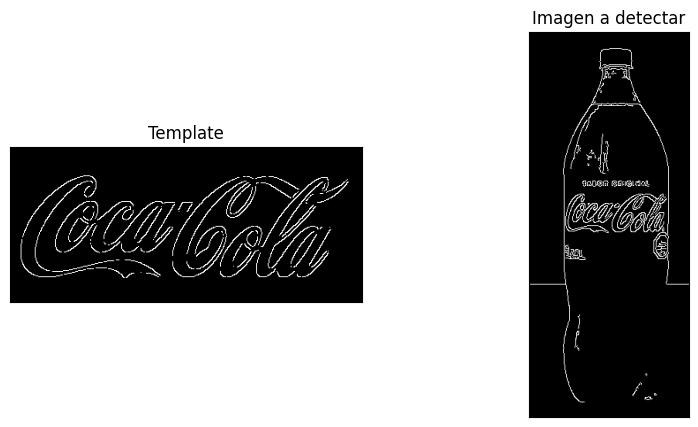

Scale:  1.0 with template 400 high template 175
400 < 207 ? 175 < 500 ?
1.0
Scale:  0.990909090909091 with template 400 high template 175
400 < 207 ? 175 < 500 ?
0.990909090909091
Scale:  0.9818181818181818 with template 396 high template 173
396 < 207 ? 173 < 500 ?
0.9818181818181818
Scale:  0.9727272727272728 with template 389 high template 170
389 < 207 ? 170 < 500 ?
0.9727272727272728
Scale:  0.9636363636363636 with template 378 high template 165
378 < 207 ? 165 < 500 ?
0.9636363636363636
Scale:  0.9545454545454546 with template 364 high template 159
364 < 207 ? 159 < 500 ?
0.9545454545454546
Scale:  0.9454545454545454 with template 347 high template 152
347 < 207 ? 152 < 500 ?
0.9454545454545454
Scale:  0.9363636363636364 with template 328 high template 144
328 < 207 ? 144 < 500 ?
0.9363636363636364
Scale:  0.9272727272727272 with template 307 high template 135
307 < 207 ? 135 < 500 ?
0.9272727272727272
Scale:  0.9181818181818182 with template 285 high template 125
285 < 207 ? 125

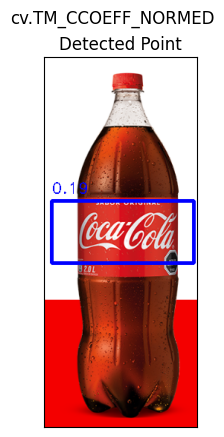

In [156]:

path_img=r"C:\Users\santi\OneDrive\Escritorio\Entrgas_Vis_Comp\EntregasVisComp\TP3\images\coca_logo_1.png"
detect_img(path_temp, path_img,'cv.TM_CCOEFF_NORMED',0.1,0,False,multi_det=0)

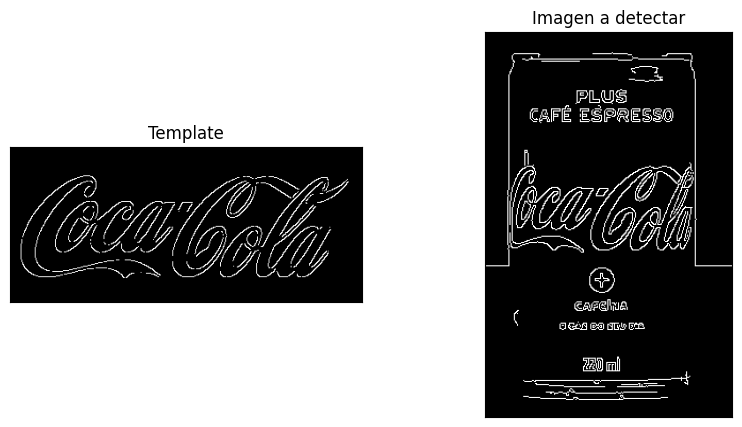

Scale:  1.0 with template 400 high template 175
400 < 233 ? 175 < 363 ?
1.0
Scale:  0.990909090909091 with template 400 high template 175
400 < 233 ? 175 < 363 ?
0.990909090909091
Scale:  0.9818181818181818 with template 396 high template 173
396 < 233 ? 173 < 363 ?
0.9818181818181818
Scale:  0.9727272727272728 with template 389 high template 170
389 < 233 ? 170 < 363 ?
0.9727272727272728
Scale:  0.9636363636363636 with template 378 high template 165
378 < 233 ? 165 < 363 ?
0.9636363636363636
Scale:  0.9545454545454546 with template 364 high template 159
364 < 233 ? 159 < 363 ?
0.9545454545454546
Scale:  0.9454545454545454 with template 347 high template 152
347 < 233 ? 152 < 363 ?
0.9454545454545454
Scale:  0.9363636363636364 with template 328 high template 144
328 < 233 ? 144 < 363 ?
0.9363636363636364
Scale:  0.9272727272727272 with template 307 high template 135
307 < 233 ? 135 < 363 ?
0.9272727272727272
Scale:  0.9181818181818182 with template 285 high template 125
285 < 233 ? 125

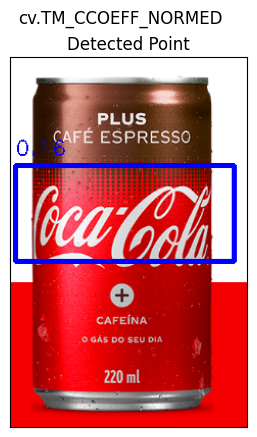

In [157]:
path_img=r"C:\Users\santi\OneDrive\Escritorio\Entrgas_Vis_Comp\EntregasVisComp\TP3\images\coca_logo_2.png"
detect_img(path_temp, path_img,'cv.TM_CCOEFF_NORMED',0.1,0,False,multi_det=0)

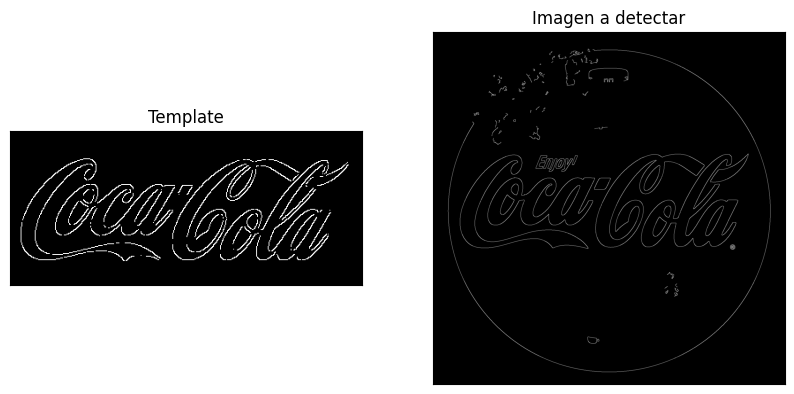

Scale:  1.0 with template 400 high template 175
400 < 1389 ? 175 < 1389 ?
1.0
Scale:  0.990909090909091 with template 1389 high template 607
1389 < 1389 ? 607 < 1389 ?
0.990909090909091
Scale:  0.9818181818181818 with template 1376 high template 601
1376 < 1389 ? 601 < 1389 ?
0.9818181818181818
Scale:  0.9727272727272728 with template 1351 high template 590
1351 < 1389 ? 590 < 1389 ?
0.9727272727272728
Scale:  0.9636363636363636 with template 1314 high template 574
1314 < 1389 ? 574 < 1389 ?
0.9636363636363636
Scale:  0.9545454545454546 with template 1266 high template 553
1266 < 1389 ? 553 < 1389 ?
Escala 0.9545454545454546 aceptada max val: 0.11090826988220215
0.9545454545454546


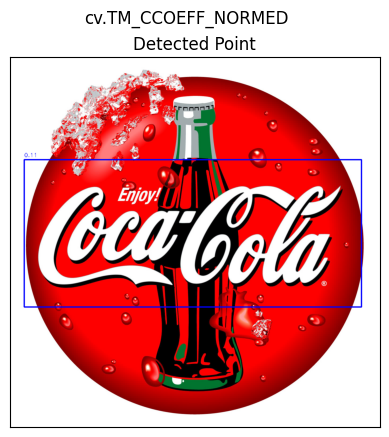

In [158]:
path_img=r"C:\Users\santi\OneDrive\Escritorio\Entrgas_Vis_Comp\EntregasVisComp\TP3\images\COCA-COLA-LOGO.jpg"
detect_img(path_temp, path_img,'cv.TM_CCOEFF_NORMED',0.1,0,False,multi_det=0)

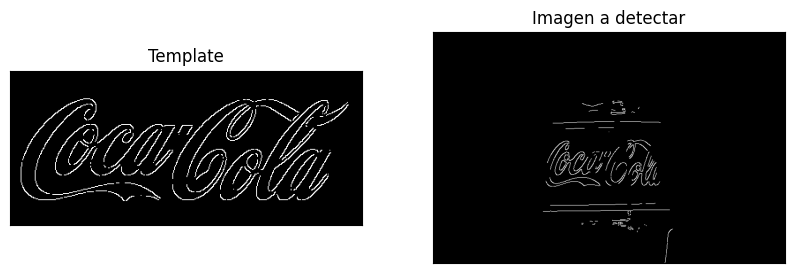

Scale:  1.0 with template 400 high template 175
400 < 687 ? 175 < 450 ?
1.0
Scale:  0.990909090909091 with template 687 high template 300
687 < 687 ? 300 < 450 ?
0.990909090909091
Scale:  0.9818181818181818 with template 681 high template 297
681 < 687 ? 297 < 450 ?
0.9818181818181818
Scale:  0.9727272727272728 with template 669 high template 292
669 < 687 ? 292 < 450 ?
0.9727272727272728
Scale:  0.9636363636363636 with template 651 high template 284
651 < 687 ? 284 < 450 ?
0.9636363636363636
Scale:  0.9545454545454546 with template 627 high template 274
627 < 687 ? 274 < 450 ?
0.9545454545454546
Scale:  0.9454545454545454 with template 598 high template 262
598 < 687 ? 262 < 450 ?
0.9454545454545454
Scale:  0.9363636363636364 with template 565 high template 248
565 < 687 ? 248 < 450 ?
0.9363636363636364
Scale:  0.9272727272727272 with template 529 high template 232
529 < 687 ? 232 < 450 ?
0.9272727272727272
Scale:  0.9181818181818182 with template 491 high template 215
491 < 687 ? 215

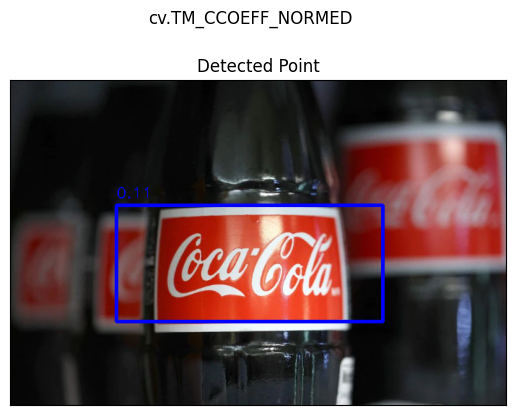

In [167]:
path_img=r"C:\Users\santi\OneDrive\Escritorio\Entrgas_Vis_Comp\EntregasVisComp\TP3\images\logo_1.png"
detect_img(path_temp, path_img,'cv.TM_CCOEFF_NORMED',0.1,0,False,multi_det=0)

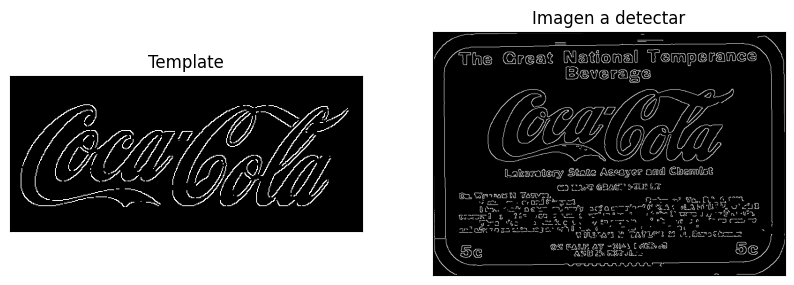

Scale:  1.0 with template 400 high template 175
400 < 715 ? 175 < 493 ?
1.0
Scale:  0.990909090909091 with template 715 high template 312
715 < 715 ? 312 < 493 ?
0.990909090909091
Scale:  0.9818181818181818 with template 708 high template 309
708 < 715 ? 309 < 493 ?
0.9818181818181818
Scale:  0.9727272727272728 with template 695 high template 303
695 < 715 ? 303 < 493 ?
0.9727272727272728
Scale:  0.9636363636363636 with template 676 high template 295
676 < 715 ? 295 < 493 ?
0.9636363636363636
Scale:  0.9545454545454546 with template 651 high template 284
651 < 715 ? 284 < 493 ?
0.9545454545454546
Scale:  0.9454545454545454 with template 621 high template 271
621 < 715 ? 271 < 493 ?
0.9454545454545454
Scale:  0.9363636363636364 with template 587 high template 256
587 < 715 ? 256 < 493 ?
0.9363636363636364
Scale:  0.9272727272727272 with template 550 high template 240
550 < 715 ? 240 < 493 ?
Escala 0.9272727272727272 aceptada max val: 0.10325898230075836
0.9272727272727272


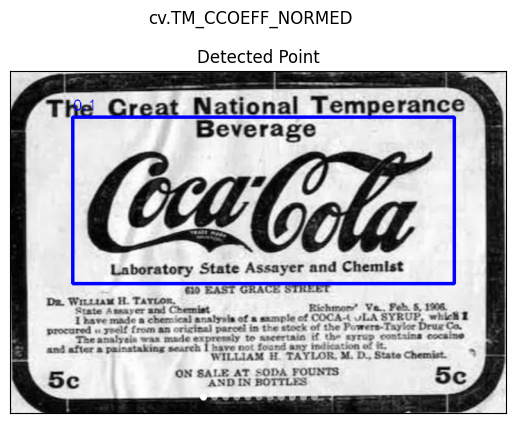

In [164]:
path_img=r"C:\Users\santi\OneDrive\Escritorio\Entrgas_Vis_Comp\EntregasVisComp\TP3\images\coca_retro_1.png"
detect_img(path_temp, path_img,'cv.TM_CCOEFF_NORMED',0.1,0,False,multi_det=0)

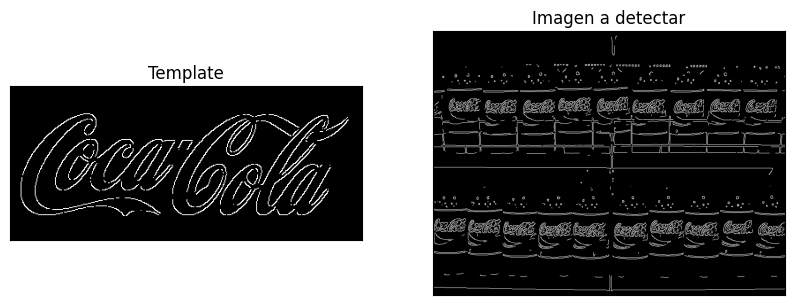

Scale:  1.0 with template 400 high template 175
400 < 799 ? 175 < 598 ?
1.0
Scale:  0.990909090909091 with template 799 high template 349
799 < 799 ? 349 < 598 ?
0.990909090909091
Scale:  0.9818181818181818 with template 792 high template 346
792 < 799 ? 346 < 598 ?
0.9818181818181818
Scale:  0.9727272727272728 with template 778 high template 340
778 < 799 ? 340 < 598 ?
0.9727272727272728
Scale:  0.9636363636363636 with template 757 high template 331
757 < 799 ? 331 < 598 ?
0.9636363636363636
Scale:  0.9545454545454546 with template 729 high template 319
729 < 799 ? 319 < 598 ?
0.9545454545454546
Scale:  0.9454545454545454 with template 696 high template 304
696 < 799 ? 304 < 598 ?
0.9454545454545454
Scale:  0.9363636363636364 with template 658 high template 287
658 < 799 ? 287 < 598 ?
0.9363636363636364
Scale:  0.9272727272727272 with template 616 high template 269
616 < 799 ? 269 < 598 ?
0.9272727272727272
Scale:  0.9181818181818182 with template 571 high template 249
571 < 799 ? 249

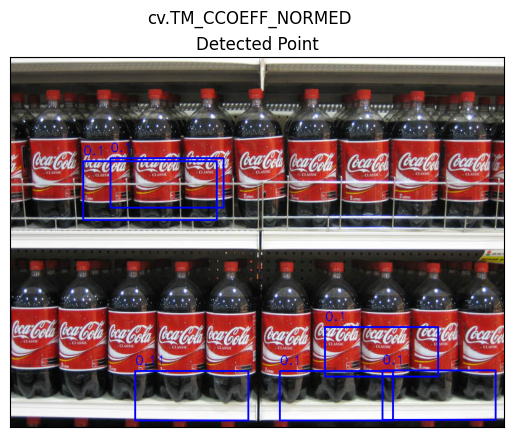

In [160]:
path_img=r"C:\Users\santi\OneDrive\Escritorio\Entrgas_Vis_Comp\EntregasVisComp\TP3\images\coca_multi.png"
detect_img(path_temp, path_img,'cv.TM_CCOEFF_NORMED',0.1,0,True,multi_det=1)